In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras import layers
from google.colab import drive
from keras.utils import to_categorical
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def correlation_matrix(self) -> None:    # Строит стандартную корреляционную матрицу
    plt.subplots(figsize=(10, 8))
    sns.heatmap(self.corr(), cmap='RdBu', annot=True, fmt=".2f", annot_kws={"size": 10, "ha": "center", "va": "center"})
    plt.xticks(range(len(self.corr().columns)), self.corr().columns);
    plt.yticks(range(len(self.corr().columns)), self.corr().columns)
    plt.title("Корреляционная матрица", fontsize=16)
    plt.show()

def compare_plot(self, column_x: int, column_y: int) -> None:   # Строит график зависимости по 2 параметрам. Ввод по индексу сравниваемых колонок
    plt.figure(figsize=(8, 6))
    title_x = self.columns[column_x]
    title_y = self.columns[column_y]
    plt.title("{} vs. \n{}".format(title_x, title_y), fontsize=13)
    sns.regplot(x=self[title_x], y=self[title_y])
    plt.grid(True)
    plt.xlabel(title_x, fontsize=11)
    plt.ylabel(title_y, fontsize=11)
    plt.show()

def compare_plots_to_parametr_row(self, column_y: int) -> None:
    num_plots = len(self.columns)
    ncols = 4
    nrows = (num_plots + ncols - 1) // ncols

    plt.figure(figsize=(ncols * 4, nrows * 3))

    for idx, i in enumerate(self.columns[:-1]):
        plt.subplot(nrows, ncols, idx + 1)
        title_y = self.columns[column_y]
        plt.title("{} vs. \n{}".format(i, title_y), fontsize=13)
        sns.regplot(x=self[i], y=self[title_y])
        plt.grid(True)
        plt.xlabel(i, fontsize=11)
        plt.ylabel(title_y, fontsize=11)

    plt.tight_layout()
    plt.show()

def compare_plots_to_parametr(self, column_y: int) -> None:    # Строит графики зависимости по всем параметрам с привязкой к column_y (индекс)
    for i in self.columns[:-1]:
      plt.figure(figsize=(8, 6))
      title_y = self.columns[column_y]
      plt.title("{} vs. \n{}".format(i, title_y), fontsize=13)
      sns.regplot(x=self[i], y=self[title_y])
      plt.grid(True)
      plt.xlabel(i, fontsize=11)
      plt.ylabel(title_y, fontsize=11)
      plt.show()

def top_correlations(self, top_n: int) -> None:        # Выводит top_n корреляционных пар
    correlation_matrix = self.corr()
    correlation_pairs = correlation_matrix.unstack()
    correlation_pairs = correlation_pairs.reset_index()
    correlation_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
    correlation_pairs = correlation_pairs[correlation_pairs['Variable 1'] != correlation_pairs['Variable 2']]
    correlation_pairs['Ordered Pair'] = correlation_pairs.apply(lambda x: tuple(sorted([x['Variable 1'], x['Variable 2']])), axis='columns')
    correlation_pairs = correlation_pairs.drop_duplicates(subset=['Ordered Pair'])
    correlation_pairs['Abs Correlation'] = correlation_pairs['Correlation'].abs()
    top_correlations = correlation_pairs.sort_values(by='Abs Correlation', ascending=False)
    for i in range(top_n):
      row = top_correlations.iloc[i]
      print(f"{i + 1}. {row['Variable 1']} AND {row['Variable 2']}: {row['Correlation']:.2f}")

def top_correlations_to_parametr(self, top_n: int, num_column: int) -> None:  # Выводит top_n корреляционных пар с привязкой к to_column
    correlation_matrix = self.corr()
    to_column = self.columns[num_column]
    correlation_pairs = correlation_matrix[[to_column]].reset_index()
    correlation_pairs.columns = ['Variable', 'Correlation']
    correlation_pairs = correlation_pairs[correlation_pairs['Variable'] != to_column]
    correlation_pairs['Abs Correlation'] = correlation_pairs['Correlation'].abs()
    top_correlations = correlation_pairs.sort_values(by='Abs Correlation', ascending=False)
    for i in range(min(top_n, len(top_correlations))):
        row = top_correlations.iloc[i]
        print(f"{i + 1}. {row['Variable']} AND {to_column}: {row['Correlation']:.2f}")

In [4]:
mobile_train = pd.read_csv('/content/drive/MyDrive/train(1).csv')
mobile_test = pd.read_csv('/content/drive/MyDrive/test.csv')
df_cars = pd.read_csv('/content/drive/MyDrive/CarPrice_Assignment.csv')

In [5]:
mobile_train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [6]:
mobile_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [7]:
mobile_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1000 non-null   int64  
 1   battery_power  1000 non-null   int64  
 2   blue           1000 non-null   int64  
 3   clock_speed    1000 non-null   float64
 4   dual_sim       1000 non-null   int64  
 5   fc             1000 non-null   int64  
 6   four_g         1000 non-null   int64  
 7   int_memory     1000 non-null   int64  
 8   m_dep          1000 non-null   float64
 9   mobile_wt      1000 non-null   int64  
 10  n_cores        1000 non-null   int64  
 11  pc             1000 non-null   int64  
 12  px_height      1000 non-null   int64  
 13  px_width       1000 non-null   int64  
 14  ram            1000 non-null   int64  
 15  sc_h           1000 non-null   int64  
 16  sc_w           1000 non-null   int64  
 17  talk_time      1000 non-null   int64  
 18  three_g  

In [8]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

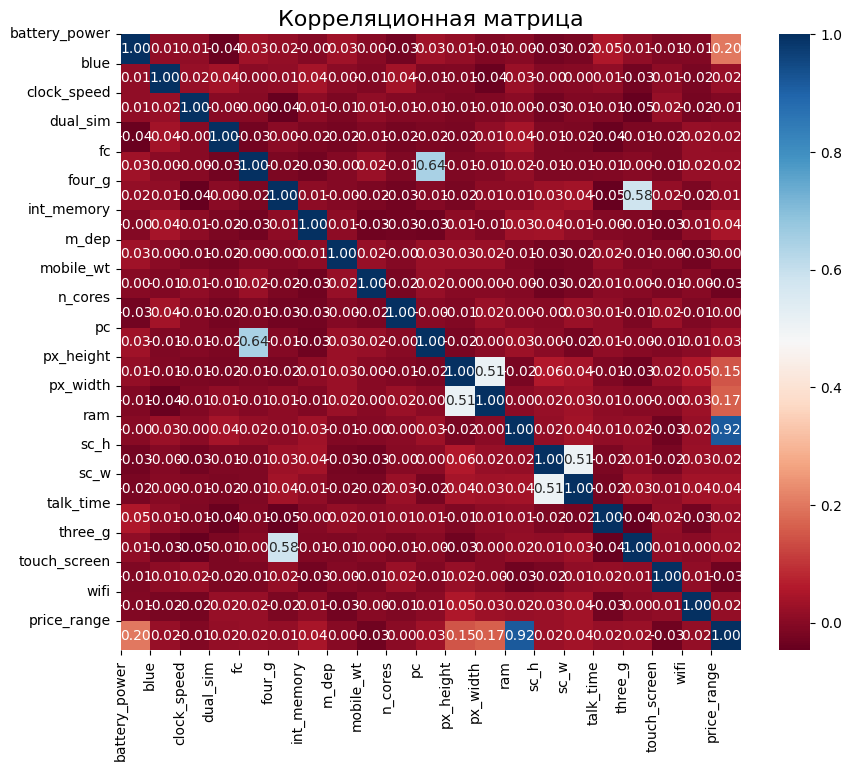

In [9]:
correlation_matrix(mobile_train)

In [10]:
df_cars_factorized = pd.DataFrame(df_cars)
df_cars = df_cars_factorized
for column in df_cars_factorized.select_dtypes(include=['object']).columns:
    df_cars_factorized[column], unique = pd.factorize(df_cars_factorized[column])

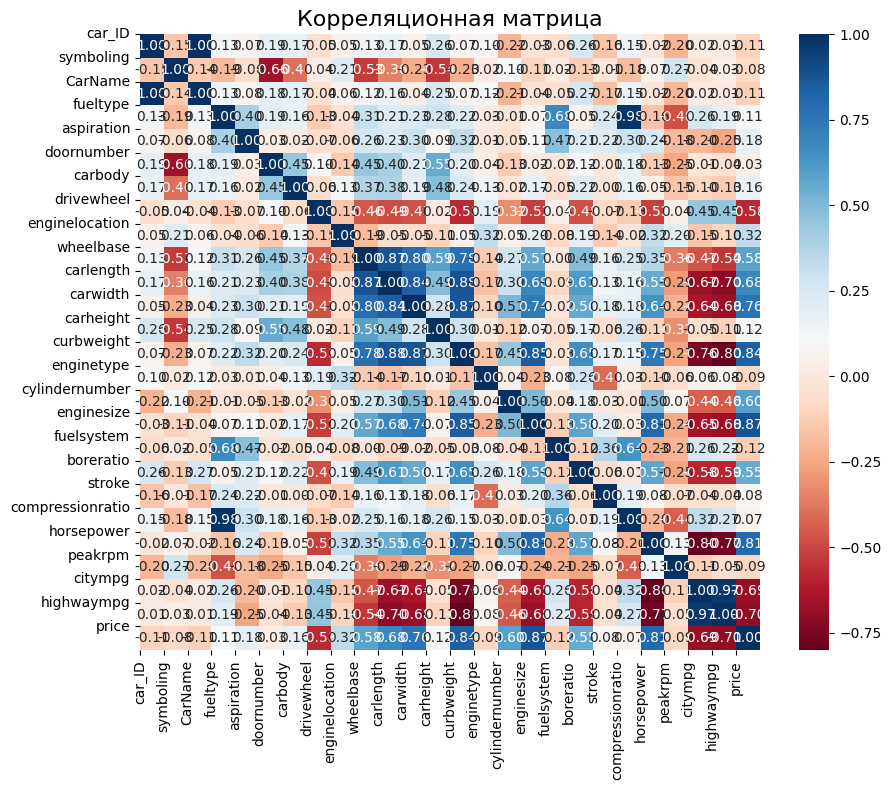

In [11]:
df_cars_values = df_cars.iloc[:, [1, 9, 10, 11, 12, 13, 16, 18, 19, 20, 21, 22, 23, 24, 25]]
correlation_matrix(df_cars_factorized)

In [12]:
top_correlations_to_parametr(df_cars_factorized, 11, 25)

1. enginesize AND price: 0.87
2. curbweight AND price: 0.84
3. horsepower AND price: 0.81
4. carwidth AND price: 0.76
5. highwaympg AND price: -0.70
6. citympg AND price: -0.69
7. carlength AND price: 0.68
8. cylindernumber AND price: 0.60
9. drivewheel AND price: -0.58
10. wheelbase AND price: 0.58
11. boreratio AND price: 0.55


In [13]:
top_correlations(df_cars_factorized, 50)

1. car_ID AND CarName: 1.00
2. fueltype AND compressionratio: 0.98
3. citympg AND highwaympg: 0.97
4. carlength AND curbweight: 0.88
5. wheelbase AND carlength: 0.87
6. enginesize AND price: 0.87
7. carwidth AND curbweight: 0.87
8. curbweight AND enginesize: 0.85
9. carlength AND carwidth: 0.84
10. curbweight AND price: 0.84
11. enginesize AND horsepower: 0.81
12. horsepower AND price: 0.81
13. horsepower AND citympg: -0.80
14. curbweight AND highwaympg: -0.80
15. wheelbase AND carwidth: 0.80
16. wheelbase AND curbweight: 0.78
17. horsepower AND highwaympg: -0.77
18. carwidth AND price: 0.76
19. curbweight AND citympg: -0.76
20. curbweight AND horsepower: 0.75
21. carwidth AND enginesize: 0.74
22. carlength AND highwaympg: -0.70
23. highwaympg AND price: -0.70
24. citympg AND price: -0.69
25. carlength AND enginesize: 0.68
26. carlength AND price: 0.68
27. fueltype AND fuelsystem: 0.68
28. enginesize AND highwaympg: -0.68
29. carwidth AND highwaympg: -0.68
30. carlength AND citympg: -0

# Mobile

In [14]:
X = mobile_train.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]].values
y = mobile_train.iloc[:, 20].values
X_test_test = mobile_test.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=3, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_test_test = scaler.fit_transform(X_test_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## TensorFlow

In [15]:
model = keras.Sequential([
    layers.Flatten(),
    layers.Dense(128, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(4, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['f1_score'])

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_test, y_test)
                    )

test_loss = model.evaluate(X_test, y_test, verbose=2)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - f1_score: 0.3177 - loss: 0.9196 - val_f1_score: 0.5315 - val_loss: 0.5842
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.5054 - loss: 0.6402 - val_f1_score: 0.5840 - val_loss: 0.5332
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.5418 - loss: 0.5975 - val_f1_score: 0.5679 - val_loss: 0.5071
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score: 0.5828 - loss: 0.5485 - val_f1_score: 0.5879 - val_loss: 0.4836
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score: 0.5640 - loss: 0.5297 - val_f1_score: 0.6249 - val_loss: 0.4589
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score: 0.5821 - loss: 0.5087 - val_f1_score: 0.6482 - val_loss: 0.4376
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - f1_score: 0.6047 - loss: 0.4769 - val_f1_score: 0.6332 - val_loss: 0.4171
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - f1_score: 0.6093 - loss: 0.4449 - val_f1_score: 0.6671

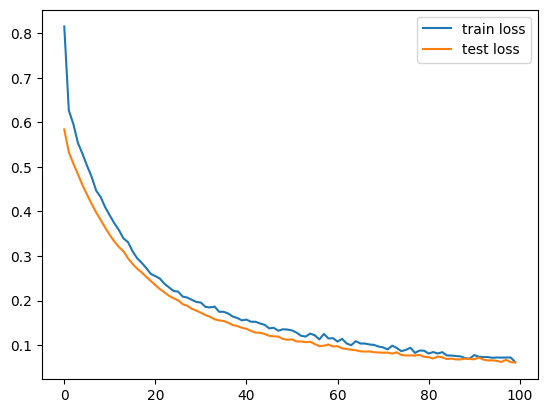

In [16]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend();

In [17]:
y_pred_tf = model.predict(X_test_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [18]:
i = 0
y_pred_tf_final = []
for _ in range(len(y_pred_tf)):
    temp = np.argmax(y_pred_tf[i])
    y_pred_tf_final.append(temp)
    i += 1

In [19]:
mobile_test['price'] = y_pred_tf_final

In [20]:
mobile_test.to_csv('test_final_tf.csv')

## PyTorch

In [21]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

X_test_test_tensor = torch.tensor(X_test_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [22]:
class NeuralNet(nn.Module):
    def __init__(self, input_size=20, num_classes=4):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.batch_norm = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.4)
        self.fc3 = nn.Linear(64, num_classes)
        self.elu = nn.ELU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.elu(x)
        x = self.fc2(x)
        x = self.elu(x)
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

model = NeuralNet(input_size=X_train.shape[1], num_classes=4)

In [23]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 100
train_loss_history = []
test_loss_history = []
val_f1_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        model.eval()
        test_running_loss = 0.0
        y_true = []
        y_pred_pt = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred_pt.extend(predicted.cpu().numpy())
                loss = criterion(outputs, labels)
                test_running_loss += loss.item()

        y_pred_pt = np.array(y_pred_pt)
        y_pred_pt = to_categorical(y_pred_pt)



    avg_train_loss = running_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)
    f1 = f1_score(y_true, y_pred_pt, average='weighted')
    val_f1_history.append(f1)
    avg_test_loss = test_running_loss / len(test_loader)
    test_loss_history.append(avg_test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, F1 Score: {f1:.4f}')

Epoch [1/100], Train Loss: 0.6168, Test Loss: 0.5376, F1 Score: 0.4195
Epoch [2/100], Train Loss: 0.4801, Test Loss: 0.4316, F1 Score: 0.5202
Epoch [3/100], Train Loss: 0.3932, Test Loss: 0.3733, F1 Score: 0.5921
Epoch [4/100], Train Loss: 0.3473, Test Loss: 0.3380, F1 Score: 0.6958
Epoch [5/100], Train Loss: 0.3139, Test Loss: 0.3045, F1 Score: 0.7877
Epoch [6/100], Train Loss: 0.2805, Test Loss: 0.2656, F1 Score: 0.8355
Epoch [7/100], Train Loss: 0.2448, Test Loss: 0.2297, F1 Score: 0.8605
Epoch [8/100], Train Loss: 0.2085, Test Loss: 0.1980, F1 Score: 0.8977
Epoch [9/100], Train Loss: 0.1865, Test Loss: 0.1750, F1 Score: 0.9103
Epoch [10/100], Train Loss: 0.1674, Test Loss: 0.1564, F1 Score: 0.9348
Epoch [11/100], Train Loss: 0.1500, Test Loss: 0.1457, F1 Score: 0.9370
Epoch [12/100], Train Loss: 0.1428, Test Loss: 0.1350, F1 Score: 0.9398
Epoch [13/100], Train Loss: 0.1322, Test Loss: 0.1290, F1 Score: 0.9471
Epoch [14/100], Train Loss: 0.1259, Test Loss: 0.1215, F1 Score: 0.9522
E

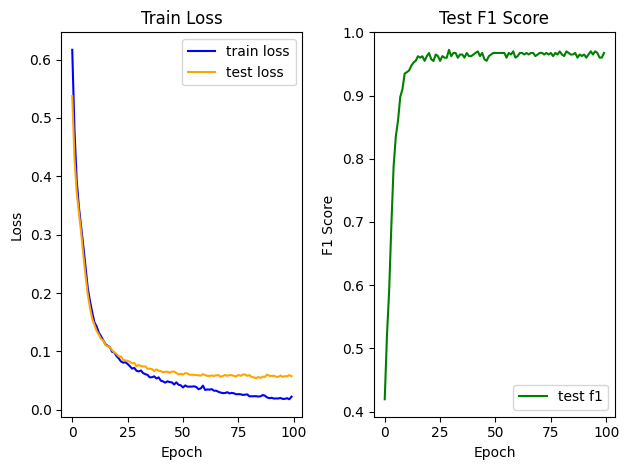

In [25]:
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='train loss', color='blue')
plt.plot(test_loss_history, label='test loss', color='orange')
plt.legend()
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(val_f1_history, label='test f1', color='green')
plt.legend()
plt.title('Test F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

In [26]:
model.eval()
y_pred_pt_final = []

with torch.no_grad():
    inputs = X_test_test_tensor.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    y_pred_pt_final = predicted.cpu().numpy()

mobile_test['price'] = y_pred_pt_final
mobile_test.to_csv('test_final_pytorch.csv', index=False)

# Cars

In [27]:
df_cars_factorized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    int64  
 3   fueltype          205 non-null    int64  
 4   aspiration        205 non-null    int64  
 5   doornumber        205 non-null    int64  
 6   carbody           205 non-null    int64  
 7   drivewheel        205 non-null    int64  
 8   enginelocation    205 non-null    int64  
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    int64  
 15  cylindernumber    205 non-null    int64  
 16  enginesize        205 non-null    int64  
 1

curbweight, enginesize, highwaympg, carwidth, carlength, drivewheel

## TensorFlow

### with factorized objects

In [28]:
X_cars = df_cars_factorized.iloc[:, [1, 3, 4, 5, 6, 8, 9, 14, 15, 17, 18, 19, 20, 21, 22, 23]].values
y_cars = df_cars_factorized.iloc[:, 25].values

X_cars_train, X_cars_test, y_cars_train, y_cars_test = train_test_split(X_cars, y_cars, train_size = 0.8, random_state=3)
scaler = StandardScaler()
X_cars_train = scaler.fit_transform(X_cars_train)
X_cars_test = scaler.fit_transform(X_cars_test)

In [29]:
model = keras.Sequential([
    layers.Flatten(),
    layers.Dense(512, activation='elu'),
    layers.Dense(256, activation='elu'),
    layers.Dense(128, activation='elu'),
    layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mae')

history = model.fit(X_cars_train, y_cars_train,
                    epochs=150,
                    batch_size=32,
                    validation_data=(X_cars_test, y_cars_test)
                    )

test_loss = model.evaluate(X_cars_test, y_cars_test, verbose=2)

Epoch 1/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 13310.4551 - val_loss: 14247.1055
Epoch 2/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 12867.5303 - val_loss: 14244.9570
Epoch 3/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 12969.0654 - val_loss: 14240.5811
Epoch 4/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 12957.3496 - val_loss: 14232.8105
Epoch 5/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 13179.7520 - val_loss: 14220.5576
Epoch 6/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 12831.8799 - val_loss: 14199.5811
Epoch 7/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 13341.7744 - val_loss: 14165.2100
Epoch 8/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 13125.8799 - val_loss: 14108.3750
Epoch 9/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 12252.6885 - val_loss: 14019.7480
Epoch 10/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 12093.1133 - val_loss: 13878.7803
Epoch 11/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 12944.8682 - val_los

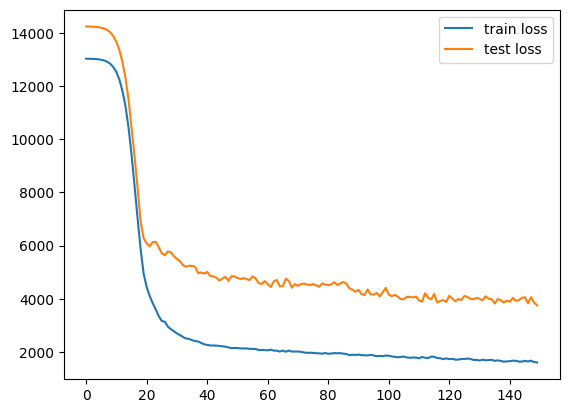

In [30]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend();

### without factorized objects

In [31]:
X_cars = df_cars_values.iloc[:, [0, 1, 4, 6, 7, 8, 9, 10, 11, 12]].values
y_cars = df_cars_values.iloc[:, 14].values

X_cars_train, X_cars_test, y_cars_train, y_cars_test = train_test_split(X_cars, y_cars, train_size = 0.8, random_state=3)
scaler = StandardScaler()
X_cars_train = scaler.fit_transform(X_cars_train)
X_cars_test = scaler.fit_transform(X_cars_test)

In [32]:
model = keras.Sequential([
    layers.Flatten(),
    layers.Dense(256, activation='elu'),
    layers.Dense(128, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mae')

history = model.fit(X_cars_train, y_cars_train,
                    epochs=300,
                    batch_size=32,
                    validation_data=(X_cars_test, y_cars_test)
                    )

test_loss = model.evaluate(X_cars_test, y_cars_test, verbose=2)

Epoch 1/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 13290.9219 - val_loss: 14247.7617
Epoch 2/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 13447.7646 - val_loss: 14246.9150
Epoch 3/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 13868.3135 - val_loss: 14245.6553
Epoch 4/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 13175.2246 - val_loss: 14243.8584
Epoch 5/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 12832.7227 - val_loss: 14241.0566
Epoch 6/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 12711.7197 - val_loss: 14236.9668
Epoch 7/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 13038.5889 - val_loss: 14231.1631
Epoch 8/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 12348.7539 - val_loss: 14223.1064
Epoch 9/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12679.2383 - val_loss: 14211.7139
Epoch 10/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12971.0039 - val_loss: 14194.9883
Epoch 11/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 13609.6055 - val_los

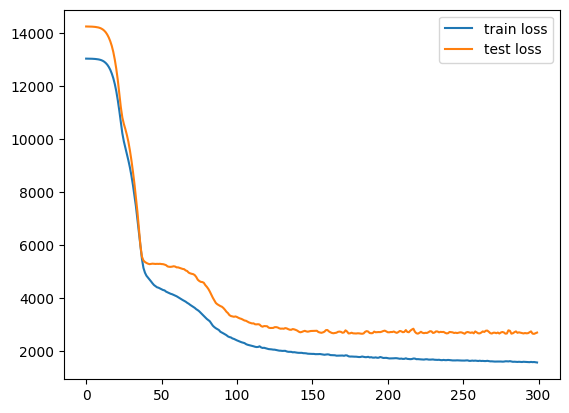

In [33]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend();

## PyTorch

In [34]:
X_train_tensor = torch.tensor(X_cars_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_cars_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_cars_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_cars_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [35]:
class NeuralNet(nn.Module):
    def __init__(self, input_size=10, num_classes=1):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.elu = nn.ELU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.elu(x)
        x = self.fc2(x)
        x = self.elu(x)
        x = self.fc3(x)
        x = self.elu(x)
        return x

model = NeuralNet(input_size=10, num_classes=1)

In [36]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 400
train_loss_history = []
test_loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    model.eval()
    test_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_test_loss = test_running_loss / len(test_loader)

    train_loss_history.append(avg_train_loss)
    test_loss_history.append(avg_test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target

Epoch [1/400], Train Loss: 14236.5306, Test Loss: 15760.1479
Epoch [2/400], Train Loss: 13006.5902, Test Loss: 15759.7012
Epoch [3/400], Train Loss: 12767.4173, Test Loss: 15759.1670
Epoch [4/400], Train Loss: 13172.5430, Test Loss: 15758.5176
Epoch [5/400], Train Loss: 12784.3366, Test Loss: 15757.7314
Epoch [6/400], Train Loss: 14324.0768, Test Loss: 15756.7734
Epoch [7/400], Train Loss: 13288.7562, Test Loss: 15755.6318
Epoch [8/400], Train Loss: 13457.7762, Test Loss: 15754.2520
Epoch [9/400], Train Loss: 13537.6294, Test Loss: 15752.6475
Epoch [10/400], Train Loss: 12642.9943, Test Loss: 15750.7578
Epoch [11/400], Train Loss: 13553.6297, Test Loss: 15748.5996
Epoch [12/400], Train Loss: 12901.2161, Test Loss: 15746.1084
Epoch [13/400], Train Loss: 12581.4912, Test Loss: 15743.2686
Epoch [14/400], Train Loss: 13036.7295, Test Loss: 15740.0098
Epoch [15/400], Train Loss: 12606.9660, Test Loss: 15736.2939
Epoch [16/400], Train Loss: 12367.1794, Test Loss: 15732.0176
Epoch [17/400], T

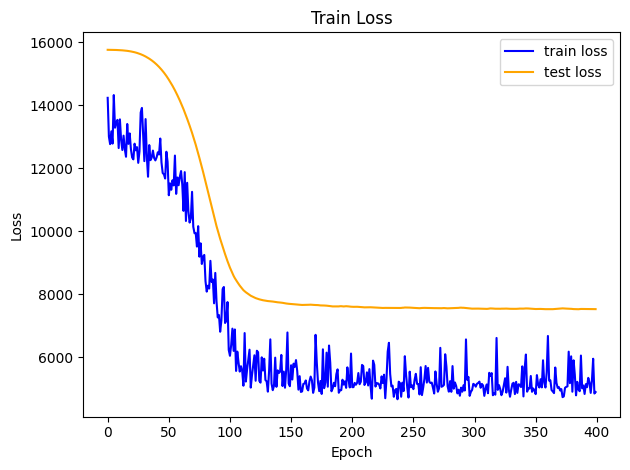

In [38]:
plt.plot(train_loss_history, label='train loss', color='blue')
plt.plot(test_loss_history, label='test loss', color='orange')
plt.legend()
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()